In [74]:
# === IMPORTS ===
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)

# === SET RANDOM SEED FOR REPRODUCIBILITY ===
np.random.seed(42)
random.seed(42)


In [76]:
# === STEP 1: LOAD AND PREPROCESS SCRAPED DATA ===
df_computers = pd.read_csv("computers.csv")
df_parts = pd.read_csv("computer_parts.csv")

df_computers["label"] = "computers"
df_parts["label"] = "computer_parts"
df_all = pd.concat([df_computers, df_parts], ignore_index=True)

df_all["title"] = df_all["title"].fillna("").str.strip()
df_all["description"] = df_all["description"].fillna("").str.strip()
df_all["text"] = df_all["title"] + " " + df_all["description"]
df_all = df_all[df_all["text"].str.strip() != ""]

df_all.to_csv("combined_data.csv", index=False)
print(f"Saved combined dataset with {len(df_all)} rows as 'combined_data.csv'.")


Saved combined dataset with 742 rows as 'combined_data.csv'.


In [78]:
# === STEP 2: PRELIMINARY MODEL FOR FLAGGING ===
df = pd.read_csv("combined_data.csv")
df["text"] = df["text"].fillna("").str.strip()
df = df[df["text"] != ""]

X = df["text"]
y = df["label"]

vectorizer = TfidfVectorizer(max_features=3000, stop_words="english")
X_tfidf = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("\nInitial Classification Report:\n", classification_report(y_test, y_pred))

# Save flagged output for human check
df["predicted_label"] = clf.predict(X_tfidf)
df["match"] = df["label"] == df["predicted_label"]
df["flagged"] = np.where(df["match"], "", "Potentially miscategorized")
df.to_csv("labeled_flagged.csv", index=False)



Initial Classification Report:
                 precision    recall  f1-score   support

computer_parts       0.84      0.87      0.85        61
     computers       0.91      0.89      0.90        88

      accuracy                           0.88       149
     macro avg       0.87      0.88      0.88       149
  weighted avg       0.88      0.88      0.88       149



In [80]:
# === STEP 3: LOAD HUMAN-VERIFIED LABELS AND CLEAN TEXT ===
df = pd.read_csv("labeled_and_flagged_with_human_check.csv")
df["human_label"] = df["human_label"].replace("computer", "computers")
df = df[df["human_label"].isin(["computers", "computer_parts"])]

df["title"] = df["title"].fillna("")
df["description"] = df["description"].fillna("")
df["text"] = df["title"] + " " + df["description"]

def simple_clean(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text.strip()

df["clean_text"] = df["text"].apply(simple_clean)
df = df[df["clean_text"] != ""]
df = df.drop_duplicates(subset=["clean_text"])


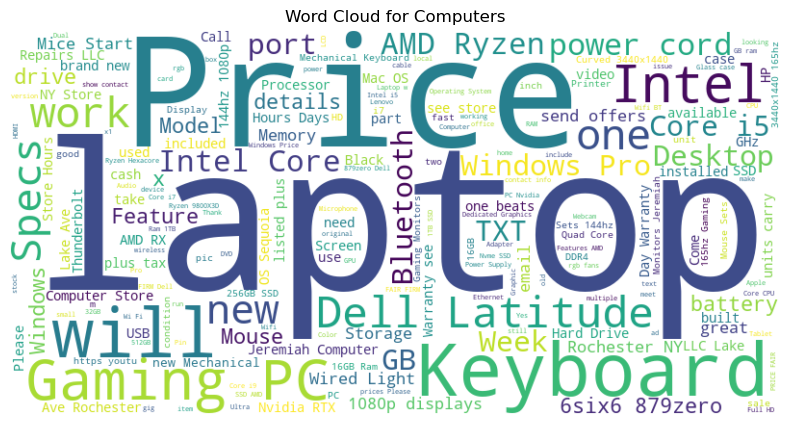

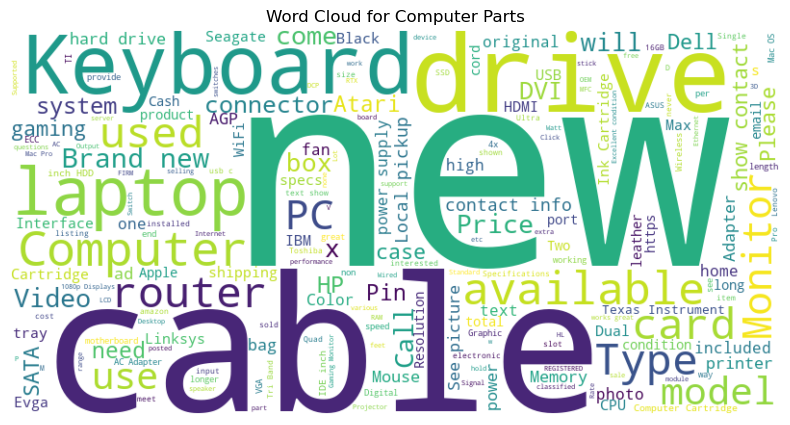

In [82]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter by class
text_computers = " ".join(df[df["label"] == "computers"]["text"])
text_parts = " ".join(df[df["label"] == "computer_parts"]["text"])

# Word cloud for 'computers'
wc_computers = WordCloud(width=800, height=400, background_color="white").generate(text_computers)
plt.figure(figsize=(10, 5))
plt.imshow(wc_computers, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Computers")
plt.show()

# Word cloud for 'computer_parts'
wc_parts = WordCloud(width=800, height=400, background_color="white").generate(text_parts)
plt.figure(figsize=(10, 5))
plt.imshow(wc_parts, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Computer Parts")
plt.show()


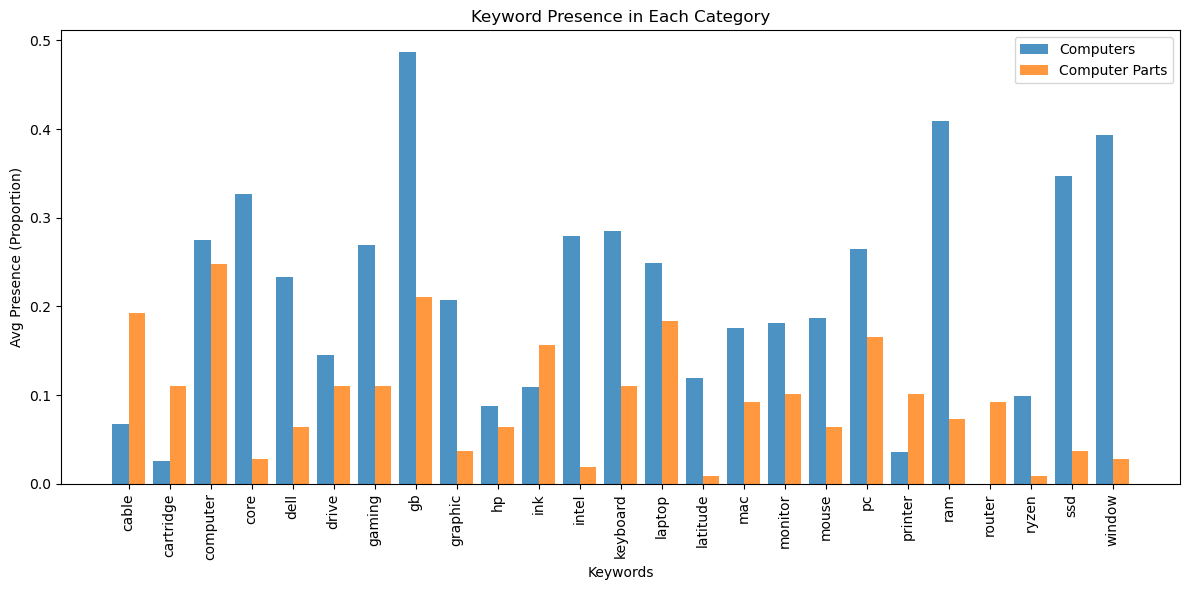

In [83]:
# Final selected keywords
keywords = list(set([
    "laptop", "dell", "gaming", "intel", "core", "window", "pc",
    "gb", "ssd", "latitude", "keyboard", "ram", "computer", "mouse",
    "mac", "graphic", "ryzen", "monitor", "cable", "printer", "hp", "router",
    "cartridge", "ink", "drive",
]))

for kw in keywords:
    col_name = f"kw_{kw}"
    if col_name not in df.columns:
        df[col_name] = df["text"].str.lower().apply(lambda x: int(kw in x))

# Compute average presence in each category
keyword_summary = {
    "keyword": [],
    "computers": [],
    "computer_parts": []
}

for kw in keywords:
    keyword_summary["keyword"].append(kw)
    keyword_summary["computers"].append(df[df["label"] == "computers"][f"kw_{kw}"].mean())
    keyword_summary["computer_parts"].append(df[df["label"] == "computer_parts"][f"kw_{kw}"].mean())

df_kw_summary = pd.DataFrame(keyword_summary).sort_values("keyword")

# Plot the grouped bar chart
plt.figure(figsize=(12, 6))
bar_width = 0.4
x = range(len(df_kw_summary))

plt.bar(x, df_kw_summary["computers"], width=bar_width, label="Computers", alpha=0.8)
plt.bar([i + bar_width for i in x], df_kw_summary["computer_parts"], width=bar_width, label="Computer Parts", alpha=0.8)

plt.xlabel("Keywords")
plt.ylabel("Avg Presence (Proportion)")
plt.title("Keyword Presence in Each Category")
plt.xticks([i + bar_width / 2 for i in x], df_kw_summary["keyword"], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


In [86]:
# === STEP 4: KEYWORD FEATURES FROM TF-IDF ANALYSIS ===
# These keywords were selected from high-frequency TF-IDF terms in each class
keywords = list(set([
    "laptop", "dell", "gaming", "intel", "core", "window", "pc",
    "gb", "ssd", "latitude", "keyboard", "ram", "computer", "mouse",
    "mac", "graphic", "ryzen", "monitor", "cable", "printer", "hp", "router",
    "cartridge", "ink", "drive",
]))

for kw in keywords:
    df[f"kw_{kw}"] = df["clean_text"].apply(lambda x: int(kw in x))

X = df[[f"kw_{kw}" for kw in keywords]]
y = df["human_label"].map({"computers": 1, "computer_parts": 0})

# === Show class balance ===
print("\nClass distribution:\n", df["human_label"].value_counts())



Class distribution:
 human_label
computer_parts    162
computers         140
Name: count, dtype: int64


In [88]:
# === STEP 5: CROSS-VALIDATION EVALUATION ===
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "MultinomialNB": MultinomialNB(),
    "RandomForest": RandomForestClassifier(random_state=42),
    "SVM": SVC()
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    accs, precs, recalls, f1s = [], [], [], []
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accs.append(accuracy_score(y_test, y_pred))
        precs.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
    print(f"\n=== {name} ===")
    print(f"Average Accuracy : {np.mean(accs):.3f}")
    print(f"Average Precision: {np.mean(precs):.3f}")
    print(f"Average Recall   : {np.mean(recalls):.3f}")
    print(f"Average F1 Score : {np.mean(f1s):.3f}")



=== LogisticRegression ===
Average Accuracy : 0.854
Average Precision: 0.885
Average Recall   : 0.793
Average F1 Score : 0.834

=== MultinomialNB ===
Average Accuracy : 0.831
Average Precision: 0.822
Average Recall   : 0.814
Average F1 Score : 0.817

=== RandomForest ===
Average Accuracy : 0.847
Average Precision: 0.856
Average Recall   : 0.807
Average F1 Score : 0.830

=== SVM ===
Average Accuracy : 0.854
Average Precision: 0.886
Average Recall   : 0.793
Average F1 Score : 0.832


In [90]:
# === STEP 6: FINAL MODEL & CONFUSION MATRIX ===
final_model = LogisticRegression(max_iter=1000)
final_model.fit(X, y)
y_pred = final_model.predict(X)

print("\nFinal Classification Report:\n", classification_report(y, y_pred, target_names=["computer_parts", "computers"]))

# Save model and vectorizer
joblib.dump(final_model, "final_logistic_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")



Final Classification Report:
                 precision    recall  f1-score   support

computer_parts       0.85      0.91      0.88       162
     computers       0.89      0.81      0.85       140

      accuracy                           0.87       302
     macro avg       0.87      0.86      0.87       302
  weighted avg       0.87      0.87      0.87       302



['tfidf_vectorizer.pkl']

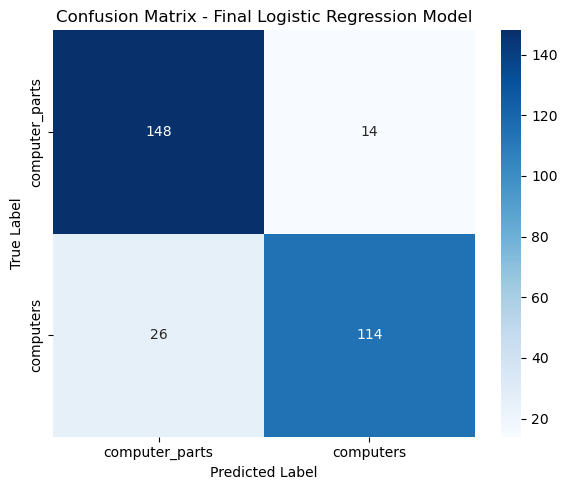

In [92]:
# Visualize confusion matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["computer_parts", "computers"],
            yticklabels=["computer_parts", "computers"])
plt.title("Confusion Matrix - Final Logistic Regression Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [72]:
# --